In [1]:
## Extrator de características e histograma

import cv2
import numpy as np
import matplotlib.pyplot as plt

def conv(img, kernel):
    """Operação de convolução entre a imagem e um kernel
    """
    kernel_qtdeLinhas, kernel_qtdeColunas = kernel.shape
    
    img_qtdeLinhas, img_qtdeColunas = img.shape
    
    k1 = round(kernel_qtdeLinhas/2)
    k2 = round(kernel_qtdeColunas/2)
    
    W = np.zeros((img_qtdeLinhas, img_qtdeColunas))
    
    for i in range(k1, img_qtdeLinhas-k1):
        for j in range(k2, img_qtdeColunas-k2):
            soma = 0
            for x in range(kernel_qtdeLinhas):
                for y in range(kernel_qtdeColunas):
                    soma = soma + kernel[x,y]*img[(i-k1)+x, (j-k2)+y]
            W[i,j] = soma
    return W

def filtro_sobel(img):
    """Obter o resultado a imagem após aplicar o filtro Sobel
    """
    qtdeLinhas, qtdeColunas = img.shape

    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]) #kernel da derivada em relação a x
    kernel_y = np.array([[1, 2, 1],[0, 0, 0], [-1, -2, -1]]) #kernel da derivada em relação a y

    Wx = conv(img, kernel_x)
    Wy = conv(img, kernel_y)

    Wxy = np.hypot(Wx,Wy)
    Wxy *= 255.0 / np.max(Wxy) #Normalizar
    return Wxy.astype(int)

def calcular_histograma(img):
    """Função para obter o vetor de histograma de uma imagem
    Apenas escala de cinza
    Retorna um vetor de 256 posições com o histograma da imagem
    """
    hist = np.zeros(256)
    qtdeLinhas, qtdeColunas = img.shape
    for i in range(qtdeLinhas):
        for j in range(qtdeColunas):
            hist[img[i,j]] = hist[img[i,j]] + 1
            
    return hist

def lbp(img):
    """Função para obter o Local Binary Pattern (LBP)
    O algoritmo desta função não trata imagens que tenham sofrido rotação ou espelhamento
    """
    qtdeLinhas, qtdeColunas = img.shape
    img2 = np.zeros((qtdeLinhas, qtdeColunas), dtype=int)
    
    for i in range(1, qtdeLinhas-1):
        for j in range(1, qtdeColunas-1):
            A = img[i-1, j]
            B = img[i-1, j+1]
            C = img[i, j+1]
            D = img[i+1, j+1]
            E = img[i+1, j]
            F = img[i+1, j-1]
            G = img[i, j-1]
            H = img[i-1, j-1]
            
            Centro = img[i,j]
            soma = 0
            
            soma += 2**7 if A > Centro else 0
            soma += 2**6 if B > Centro else 0
            soma += 2**5 if C > Centro else 0
            soma += 2**4 if D > Centro else 0
            soma += 2**3 if E > Centro else 0
            soma += 2**2 if F > Centro else 0
            soma += 2**1 if G > Centro else 0
            soma += 2**0 if H > Centro else 0
            
            img2[i,j]  = soma    
            
    return img2

def extrair_caracteristicas(img):
    """Extrai características de uma imagem retornando um histograma
    Os primeiros 256 elementos são o histograma do lbp
    Os últimos 256 elementos são o histograma do Filtro Sobel X e Y
    Retorna um histograma com total de 512 elementos
    """
    img_lbp = lbp(img)
    hist_lbp = calcular_histograma(img_lbp)
    
    img_sobel = filtro_sobel(img)
    hist_sobel = calcular_histograma(img_sobel)
    return np.append(hist_lbp, hist_sobel) #Concatenar os dois histogramas

In [2]:
#Pegar características da base
import os

def distancia(a, b):
    M = len(a)
    soma = 0
    for i in range(M):
        soma = soma + ((a[i]-b[i])**2)
    return np.sqrt(soma) 

hists = []

files_path = [os.path.abspath(x) for x in os.listdir('./') if x.endswith('.jpg')]

with open('hists.txt', 'a') as f:
    for i in files_path:
        diretorio, arquivo = path, filename = os.path.split(i)
        imagem = cv2.imread(arquivo, 0)
        carac = extrair_caracteristicas(imagem)
        hists.append((carac,arquivo))
        str_carac = " ".join(str(x) for x in carac)
        print(arquivo)
        f.write("%s, %s\n" % (str_carac, arquivo)) # Salvar em arquivos o histograma de características das imagens na base
    
print("Concluido")

Concluido


In [3]:
def normalize(hist):
    total = np.sum(hist)
    return np.divide(hist, total)

#Procurar imagem semelhante na base
def ranking(nome, hists):
    img = cv2.imread('corel1000/' + nome, 0)
    print(img.shape)
    hist_consulta = extrair_caracteristicas(img)
    d = []

    for i in hists:
        hist_consulta = normalize(hist_consulta)
        hist_query = normalize(i[0])
        d.append((distancia(hist_consulta, hist_query), i[1], hist_query)) #Calcular distância entre os histogramas

    e = sorted(d)

    plt.gray()
    for i in e[:20]:
        img = cv2.imread(i[1])
        plt.imshow(img[:,:,::-1])
        plt.show()
    return e

In [4]:
histogramas = []
with open('hists.db') as f:
    for line in f:
        a,b = line.split(',')
        l = a.split()
        l = map(lambda k : float(k), l)
        l = list(l)
        #histogramas[b.strip()] = histogramas.get(b.strip(), l)
        b= b.strip()
        histogramas.append((l, 'corel1000/' + b))

(256, 384)


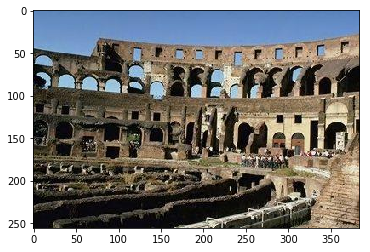

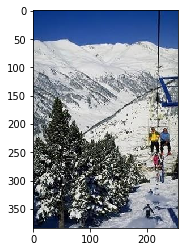

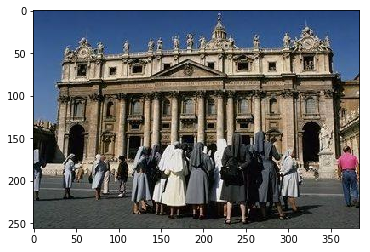

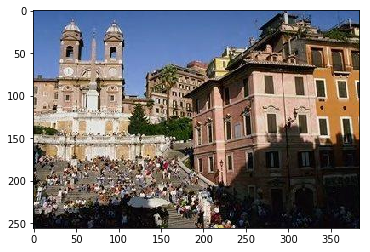

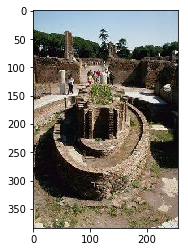

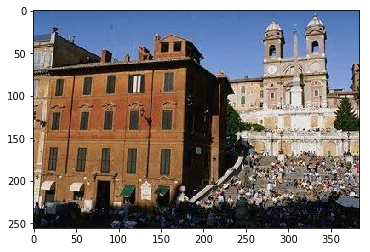

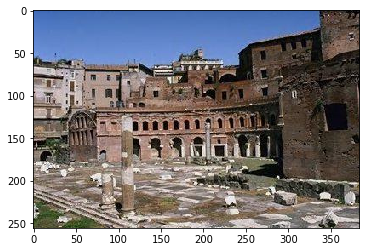

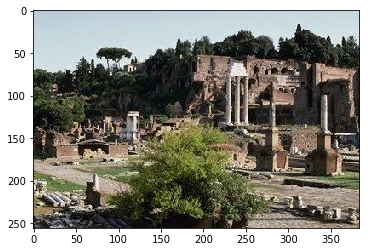

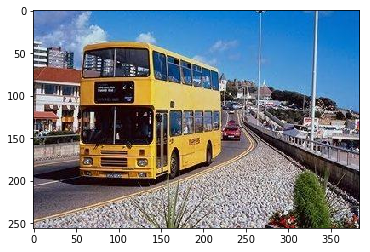

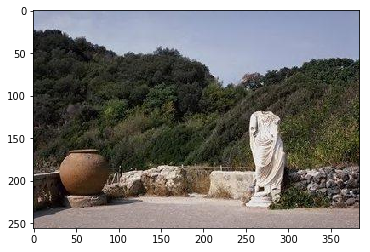

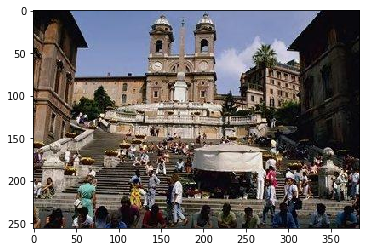

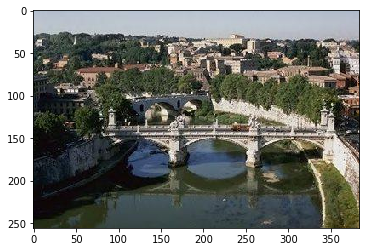

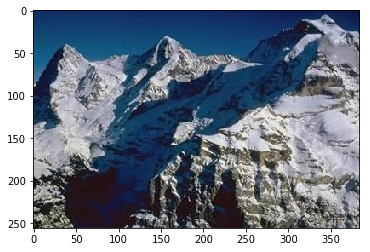

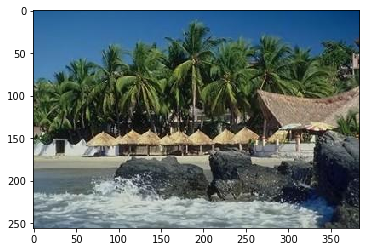

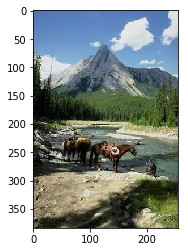

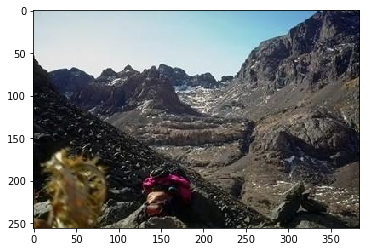

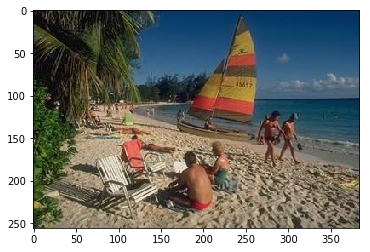

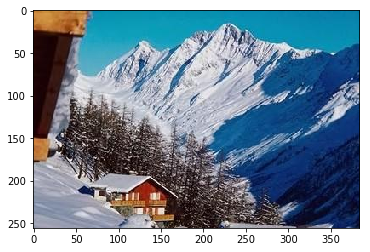

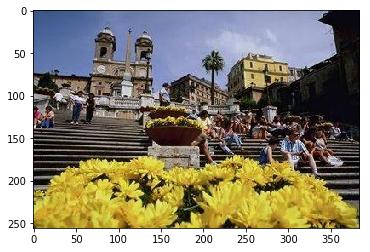

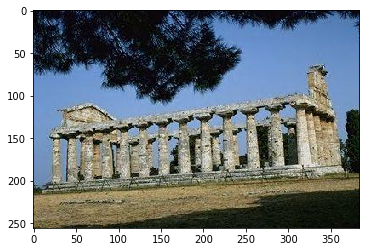

In [5]:
CONSULTA = 'Buildings4.jpg'
CLASSENOME = 'Building' 

results = ranking(CONSULTA, histogramas)
total_res = results
results = results[:80]

In [6]:
relevants = []
irrelevants = []
for elem in results:
    if CLASSENOME in elem[1]:
        relevants.append(elem)
    else:
        irrelevants.append(elem)

In [7]:
print(len(relevants), len(irrelevants))

24 56


In [8]:
dataset = []

for elem in relevants:
    dataset.append((elem[2], 1, elem[1]))
    
for elem in irrelevants:
    dataset.append((elem[2], 0, elem[1]))
print(dataset)
X = list(map(lambda k : k[0], dataset))
Y = list(map(lambda k : k[1], dataset))
Z = list(map(lambda k : k[2], dataset))
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

[(array([6.63299561e-02, 4.14530436e-03, 8.44828288e-03, 2.96020508e-03,
       5.95092773e-03, 9.00268555e-04, 3.81978353e-03, 3.86555990e-03,
       7.05973307e-03, 1.06302897e-03, 9.91821289e-04, 8.44319661e-04,
       5.62540690e-03, 5.79833984e-04, 3.55529785e-03, 3.17382812e-03,
       5.57454427e-03, 6.20524089e-04, 1.47501628e-03, 5.03540039e-04,
       1.17492676e-03, 2.79744466e-04, 7.88370768e-04, 5.59488932e-04,
       5.31005859e-03, 6.10351562e-04, 1.06302897e-03, 7.52766927e-04,
       2.91035970e-02, 7.42594401e-04, 6.98852539e-03, 3.10262044e-03,
       7.96508789e-03, 1.35294596e-03, 2.18709310e-03, 7.62939453e-04,
       1.60217285e-03, 3.66210938e-04, 8.23974609e-04, 6.30696615e-04,
       1.18509928e-03, 4.78108724e-04, 4.42504883e-04, 2.74658203e-04,
       1.22070312e-03, 3.56038411e-04, 6.10351562e-04, 5.49316406e-04,
       3.30098470e-03, 6.61214193e-04, 8.34147135e-04, 5.23885091e-04,
       8.08715820e-04, 1.93277995e-04, 7.78198242e-04, 8.23974609e-04,
    

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, Y)
knn.score(X, Y)

0.8875

In [11]:
relevants2 = []
irrelevants2 = []
for elem in total_res:
    if CLASSENOME in elem[1]:
        relevants2.append(elem)
    else:
        irrelevants2.append(elem)
datasettest = []

for elem in relevants2:
    datasettest.append((elem[2], 1, elem[1]))
    
for elem in irrelevants2:
    datasettest.append((elem[2], 0, elem[1]))
from sklearn.utils import shuffle
datasettest = shuffle(datasettest)
X2 = list(map(lambda k : k[0], datasettest))
Y2 = list(map(lambda k : k[1], datasettest))
Z2 = list(map(lambda k : k[2], datasettest))

In [17]:
y_pred = knn.predict(X2)
print(knn.score(X2, Y2))
c = 0
nova = []
for i in range(len(X2)):
    if y_pred[i] == 1:
        print(Z2[i], 'valor:', Y2[i],'predict:', y_pred[i])
        nova.append(X2[i], 1)
        nova.append(X2[i], 0)
        c += 1
        
print(c)

0.822
corel1000/Mountains46.jpg valor: 0 predict: 1
corel1000/Food46.jpg valor: 0 predict: 1
corel1000/Dinosaurs31.jpg valor: 0 predict: 1
corel1000/Elephants2.jpg valor: 0 predict: 1
corel1000/Buildings31.jpg valor: 1 predict: 1
corel1000/Buildings55.jpg valor: 1 predict: 1
corel1000/Beach96.jpg valor: 0 predict: 1
corel1000/Dinosaurs88.jpg valor: 0 predict: 1
corel1000/Mountains13.jpg valor: 0 predict: 1
corel1000/Dinosaurs60.jpg valor: 0 predict: 1
corel1000/Dinosaurs70.jpg valor: 0 predict: 1
corel1000/Dinosaurs32.jpg valor: 0 predict: 1
corel1000/Dinosaurs95.jpg valor: 0 predict: 1
corel1000/Mountains10.jpg valor: 0 predict: 1
corel1000/Beach57.jpg valor: 0 predict: 1
corel1000/Buildings73.jpg valor: 1 predict: 1
corel1000/Buildings16.jpg valor: 1 predict: 1
corel1000/Buildings83.jpg valor: 1 predict: 1
corel1000/Beach33.jpg valor: 0 predict: 1
corel1000/Elephants74.jpg valor: 0 predict: 1
corel1000/Buildings81.jpg valor: 1 predict: 1
corel1000/Buildings88.jpg valor: 1 predict: 1


In [13]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y2, y_pred))

[[746 154]
 [ 24  76]]
